In [23]:

# Some of these may now be unneeded, I tested many methods of image feature editing

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
from sklearn import svm 
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline as pipe
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from skimage.filters import threshold_otsu
from skimage import filters, img_as_float
import scipy.ndimage as ndi
from skimage import util
from skimage import exposure
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator


In [24]:
# Load the data from Keras

baseDir = os.path.dirname(os.path.abspath('__file__')) + '/'
classesName = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

# Load training data from keras
# Split and set up data for preprocessing

(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()
xVal = xTrain[49000:, :].astype(np.float)
yVal = np.squeeze(yTrain[49000:, :])
xTrain = xTrain[:49000, :].astype(np.float)
yTrain = np.squeeze(yTrain[:49000, :])
yTest = np.squeeze(yTest)
xTest = xTest.astype(np.float)


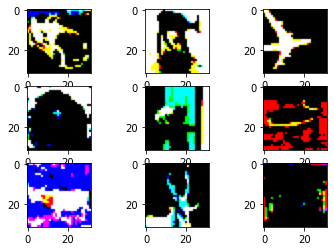

In [25]:
# Using Keras ImageDataGenerator,
# -Normalize features
# -Center Featurwise
# -Tested whitening with no positive results

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
datagen.fit(xTrain)

# Print some edited images

for X_batch, y_batch in datagen.flow(xTrain, yTrain, batch_size=9):
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(32, 32, 3).astype('uint8'), cmap=plt.get_cmap('gray'))
	plt.show()
	break

In [26]:
# Check for the shape of elements
print(xTrain.shape)
print(yTrain.shape)

(49000, 32, 32, 3)
(49000,)


In [27]:
# Reshape data
xTrain = np.reshape(xTrain, (xTrain.shape[0], -1))
xVal = np.reshape(xVal, (xVal.shape[0], -1))
xTest = np.reshape(xTest, (xTest.shape[0], -1))

In [28]:
# Sanity check for the new shape of elements
print(xTrain.shape) 
print(xVal.shape)
print(xTest.shape)

(49000, 3072)
(1000, 3072)
(10000, 3072)


In [29]:
# Reshape Data
xTrain=xTrain[:10000,:]
yTrain=yTrain[:10000]

In [30]:
# Sanity check for the new shape of elements
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(10000, 3072)
(10000,)
(10000, 3072)
(10000,)


Text(0, 0.5, 'cumulative explained variance')

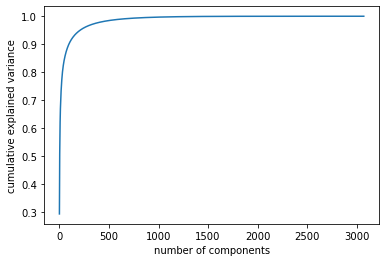

In [31]:
# Graph variance of data given number of components retained
# At around 150, it reaches 92% variance retention
combined=np.vstack((xTrain,xVal))
pca = PCA().fit(combined)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [32]:
# Set up PCA
pca = PCA(n_components=150)
pca.fit(combined)
projected = pca.transform(combined)

In [33]:
# Sanity check for the shape of projected elements
print(pca.explained_variance_.shape)
print(pca.components_.shape)
print(combined.shape)
print(projected.shape)

(150,)
(150, 3072)
(11000, 3072)
(11000, 150)


In [34]:
# Reshape data after projecting
xTrain=projected[:10000,:]
yTrain=yTrain
xTest=projected[10000:,:]
yTest=yVal

In [35]:
# Sanity check for the shape of projected elements
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(10000, 150)
(10000,)
(1000, 150)
(1000,)


In [36]:
# Fit the rbf model
svc = svm.SVC(probability=False,  kernel="rbf", C=8,gamma=.0000000710)
svc.fit(xTrain, yTrain)

7.1e-08


In [37]:
# Estimate the Training accuracy
pred = svc.predict(xTrain)
acc_train = np.mean(pred == yTrain)
print('Train Accuracy = {0:f}'.format(acc_train))

Train Accuracy = 0.936900


In [38]:
# Estimate the Test Accuracy
pred = svc.predict(xTest)
acc_test = np.mean(pred == yTest)
print('Test Accuracy = {0:f}'.format(acc_test))

Test Accuracy = 0.498000


In [39]:
# Fit the poly model, degree 3
svc = svm.SVC(probability=False,  kernel="poly", degree=3, C=8, gamma=.000000073)
svc.fit(xTrain, yTrain)

SVC(C=8, gamma=7.3e-08, kernel='poly')

In [40]:
# Estimate the Training accuracy
pred = svc.predict(xTrain)
acc_train = np.mean(pred == yTrain)
print('Train Accuracy = {0:f}'.format(acc_train))

Train Accuracy = 0.884800


In [41]:
# Estimate the Test Accuracy
pred = svc.predict(xTest)
acc_test = np.mean(pred == yTest)
print('Test Accuracy = {0:f}'.format(acc_test))

Test Accuracy = 0.430000


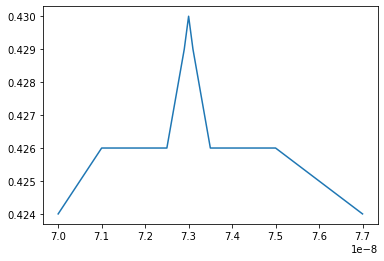

In [42]:
# Tested Gamma Values for Polynomial
# -Default for degree and other values such as C
# -C was determined after testing it for the rbf

#.424/.0000000770
#.426/.0000000750
#.426/.0000000735
#.429/.0000000731
#.430/.0000000730
#.429/.0000000729
#.426/.0000000725
#.426/.0000000710
#.424/.0000000700

plt.plot(
    [.0000000770,.0000000750,.0000000735,.0000000731,.0000000730,.0000000729,.0000000725,.0000000710,.0000000700],
    [.424,.426,.426,.429,.430,.429,.426,.426,.424])

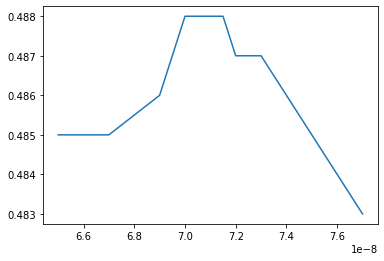

In [43]:
# Tested Gamma Values for rbf
# -Default for degree and other values such as C

#.485/.0000000650
#.485/.0000000670
#.486/.0000000690
#.488/.0000000700
#.488/.0000000710
#.488/.0000000715
#.487/.0000000720
#.487/.0000000727
#.487/.0000000729
#.487/.0000000730
#.485/.0000000750
#.483/.0000000770

plt.plot(
    [.0000000650,.0000000670,.0000000690,.0000000700,.0000000710,.0000000715,.0000000720,.0000000727,.0000000729,.0000000730,.0000000750,.0000000770],
    [.485,.485,.486,.488,.488,.488,.487,.487,.487,.487,.485,.483])

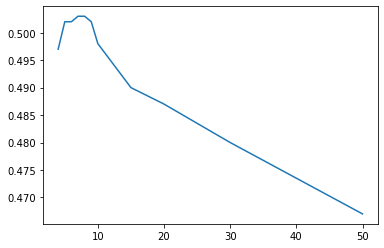

In [44]:
# Tested C values for rbf
# -Gamma set to best found value
# -Gamma=.0000000715
# -Using rbf due to better performance
# -Varying C on the poly model got similar results

#.497/4
#.502/5
#.502/6
#.503/7
#.503/8
#.502/9
#.498/10
#.490/15
#.487/20
#.480/30
#.467/50

plt.plot(
    [4,5,6,7,8,9,10,15,20,30,50],
    [.497,.502,.502,.503,.503,.502,.498,.490,.487,.480,.467])